# DAGGER

In [1]:
from formulas import RealEstateFormulas
from computation_graph import ComputationGraph

In [2]:
cg = ComputationGraph(RealEstateFormulas)
cg.create_graph()
cg.get_required_inputs()

['purchase_price',
 'closing_costs_multiplier',
 'down_payment',
 'renovations_at_purchase']

{'closing_costs': 6000.0}


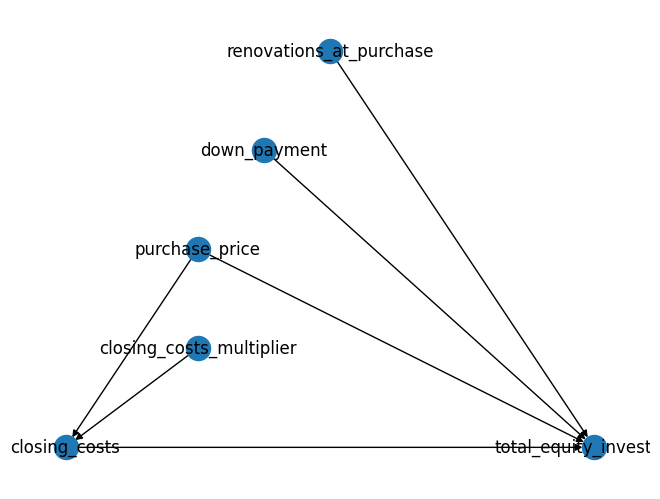

In [8]:
inputs = dict(
    purchase_price = 300000,
    closing_costs_multiplier = 0.02,
    tax_rate = 0.0186,
    down_payment = 60000,
    renovations_at_purchase = 15000,
)
cg.run_graph(inputs)
print(cg.query_results("closing_costs"))
cg.visualize_graph()

{'closing_costs': 9000.0}

# Development work

In [36]:
class RealEstateFormulas:
    """Real Estate Property Investment Calcs"""

    # def __init__(self):
    #     pass

    def property_taxes(tax_rate, purchase_price):
        return tax_rate * purchase_price
    
    def closing_costs(purchase_price, closing_costs_multiplier):
        return purchase_price * closing_costs_multiplier
    
    def total_equity_investment(down_payment, purchase_price, closing_costs, renovations_at_purchase):
        return (
            down_payment * (
                purchase_price + closing_costs + renovations_at_purchase
            )
        )

In [37]:
dag._method_map

{'closing_costs': {'method_obj': <function __main__.RealEstateFormulas.closing_costs(purchase_price, closing_costs_multiplier)>,
  'params': ['purchase_price', 'closing_costs_multiplier']},
 'property_taxes': {'method_obj': <function __main__.RealEstateFormulas.property_taxes(tax_rate, purchase_price)>,
  'params': ['tax_rate', 'purchase_price']},
 'total_equity_investment': {'method_obj': <function __main__.RealEstateFormulas.total_equity_investment(down_payment, purchase_price, closing_costs, renovations_at_purchase)>,
  'params': ['down_payment',
   'purchase_price',
   'closing_costs',
   'renovations_at_purchase']}}

In [38]:
inspect.signature(RealEstateFormulas.total_equity_investment).parameters.items()

odict_items([('down_payment', <Parameter "down_payment">), ('purchase_price', <Parameter "purchase_price">), ('closing_costs', <Parameter "closing_costs">), ('renovations_at_purchase', <Parameter "renovations_at_purchase">)])

In [65]:
import networkx as nx
import matplotlib.pyplot as plt
import inspect

class DAGGER:

    def __init__(self, formula_source):
        # calculation_params = 1
        self.G = nx.DiGraph()
        self.formula_source = formula_source
        self.formulas = formula_source()
        self._method_map = self._create_method_map()

    def _create_method_map(self) -> dict:

        # Collect all methods in the formaulas class that don't start with an underscore
        # By convention, these will be our 'formulas'
        all_members = dir(self.formulas)
        public_methods = [
            member for member in all_members
            if callable(getattr(self.formulas, member)) and not member.startswith('_')
        ]

        # Crate mapping dictionary with keys as method name and values as a list of parameters
        method_parameter_mapping = {}
        for method_name in public_methods:

            # get method from its name
            method_obj = getattr(self.formula_source, method_name)

            # get method signature
            params = inspect.signature(method_obj).parameters.items()

            # method_obj, params = self._get_method_obj_w_parameters(method_name)
            method_parameter_mapping[method_name] = dict()
            # method_parameter_mapping[method_name] = dict()
            method_parameter_mapping[method_name]["method_obj"] = method_obj
            method_parameter_mapping[method_name]["params"] = [param[0] for param in params]

        return method_parameter_mapping

    def create_graph(self) -> None:

        # Add nodes - one per method and parameter
        for method_name in self._method_map.keys():

            print(f"adding node for {method_name}")
            self.G.add_node(
                method_name,
                func=self._method_map[method_name]['method_obj'],
                args=self._method_map[method_name]['params'],
                value=None
            )

        # Add edge from the parameter nodes to respective target methods
        for method_name in self._method_map.keys():
            for param in self._method_map[method_name]['params']:
                self.G.add_edge(param, method_name)

        return None

    def run_graph(self, inputs) -> None:

        # --- Create dictionary of dictionaries to set node attributes --- #
        dod = {}
        for k, v in inputs.items():
            dod[k] = dict()
            dod[k]["value"] = v

        nx.set_node_attributes(self.G, dod)

        # --- Run the graph --- #
        for node in nx.topological_sort(self.G):
            print("node: ", node)
            func = self.G.nodes[node].get("func")
            if func:
                argmap = self.G.nodes[node]["args"]
                inputs = {arg: self.G.nodes[arg]["value"] for arg in argmap}
                print("inputs: ", inputs)
                self.G.nodes[node]["value"] = func(**inputs)

        return None

    def visualize_graph(self):
        pos = nx.spring_layout(self.G)
        nx.draw(self.G, pos, with_labels=True)
        plt.show()

adding node for closing_costs
adding node for property_taxes
adding node for total_equity_investment


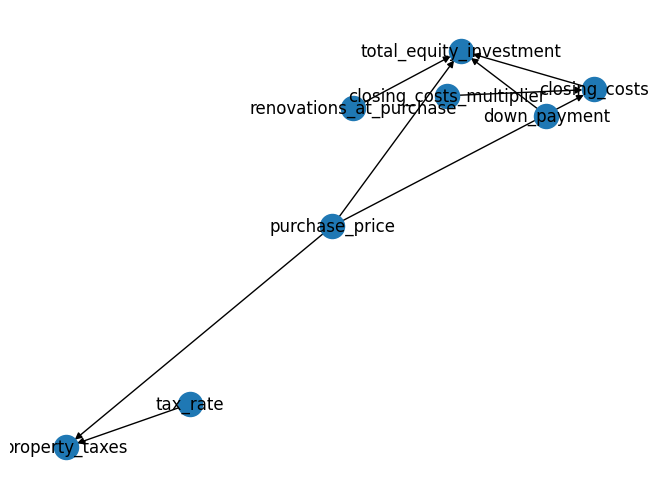

In [66]:
dag = DAGGER(RealEstateFormulas)
dag.create_graph()
# dag.run_graph()
dag.visualize_graph()

node:  purchase_price
node:  closing_costs_multiplier
node:  tax_rate
node:  down_payment
node:  renovations_at_purchase
node:  closing_costs
inputs:  {'purchase_price': 300000, 'closing_costs_multiplier': 0.03}
node:  property_taxes
inputs:  {'tax_rate': 0.0186, 'purchase_price': 300000}
node:  total_equity_investment
inputs:  {'down_payment': 60000, 'purchase_price': 300000, 'closing_costs': 9000.0, 'renovations_at_purchase': 15000}


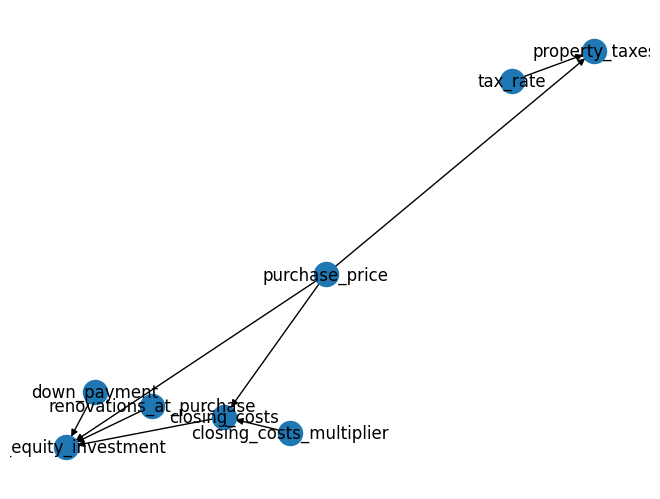

In [69]:
inputs = dict(
    tax_rate = 0.0186,
    purchase_price = 300000,
    closing_costs_multiplier = 0.03,
    renovations_at_purchase = 15000,
    down_payment = 60000
)
dag.run_graph(inputs)
dag.visualize_graph()

In [ ]:
inputs = dict(
    tax_rate = 0.0186,
    purchase_price = 300000,
    closing_costs_multiplier = 0.03,
    renovations_at_purchase = 15000,
    down_payment = 60000
)

class DAGRunner:

    def __init__(self, dag, inputs):
        self.inputs = inputs
        self.dag = dag

    def set_input_values(self):
        dod = {}
        for k, v in self.inputs.items():
            dod[k] = dict()
            dod[k]["value"] = v
            
        nx.set_node_attributes(self.dag, dod)

    def run_graph(self) -> nx.DiGraph:
        for node in nx.topological_sort(self.dag):
            print("node: ", node)
            func = self.dag.nodes[node].get("func")
            if func:
                argmap = self.dag.nodes[node]["args"]
                inputs = {arg: self.dag.nodes[arg]["value"] for arg in argmap}
                print("inputs: ", inputs)
                self.dag.nodes[node]["value"] = func(**inputs)

        return dag

set_input_values(dag.G)

In [57]:
def run_graph(g):
    for node in nx.topological_sort(g):
        print("node: ", node)
        func = g.nodes[node].get("func")
        if func:
            argmap = g.nodes[node]["args"]
            inputs = {arg: g.nodes[arg]["value"] for arg in argmap}
            print("inputs: ", inputs)
            g.nodes[node]["value"] = func(**inputs)

run_graph(dag.G)

node:  purchase_price
node:  closing_costs_multiplier
node:  tax_rate
node:  down_payment
node:  renovations_at_purchase
node:  closing_costs
inputs:  {'purchase_price': 300000, 'closing_costs_multiplier': 0.03}
node:  property_taxes
inputs:  {'tax_rate': 0.0186, 'purchase_price': 300000}
node:  total_equity_investment
inputs:  {'down_payment': 60000, 'purchase_price': 300000, 'closing_costs': 9000.0, 'renovations_at_purchase': 15000}


In [9]:
func = dag.G.nodes["total_equity_investment"].get("func")
func

<bound method RealEstateFormulas.total_equity_investment of <__main__.RealEstateFormulas object at 0x000002093B28BBD0>>

In [6]:
dag.G.nodes.data('value')

NodeDataView({'closing_costs': None, 'property_taxes': None, 'total_equity_investment': None, 'purchase_price': 300000, 'closing_costs_multiplier': 0.03, 'tax_rate': 0.0186, 'renovations_at_purchase': 15000}, data='value')

In [7]:
for node in nx.topological_sort(dag.G):
    print({node: dag.G.nodes[node]})

{'purchase_price': {'value': 300000}}
{'closing_costs_multiplier': {'value': 0.03}}
{'tax_rate': {'value': 0.0186}}
{'renovations_at_purchase': {'value': 15000}}
{'closing_costs': {'func': <bound method RealEstateFormulas.closing_costs of <__main__.RealEstateFormulas object at 0x000002093B28BBD0>>, 'args': ['purchase_price', 'closing_costs_multiplier'], 'value': None}}
{'property_taxes': {'func': <bound method RealEstateFormulas.property_taxes of <__main__.RealEstateFormulas object at 0x000002093B28BBD0>>, 'args': ['tax_rate', 'purchase_price'], 'value': None}}
{'total_equity_investment': {'func': <bound method RealEstateFormulas.total_equity_investment of <__main__.RealEstateFormulas object at 0x000002093B28BBD0>>, 'args': ['purchase_price', 'closing_costs', 'renovations_at_purchase'], 'value': None}}
